In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.image as mpimg
import seaborn as sns
import sys
!{sys.executable} -m pip install wget
!{sys.executable} -m pip install shutil
!{sys.executable} -m pip install split-folders

import splitfolders

import os
from shutil import unpack_archive
from shutil import rmtree
pd.set_option("display.max_columns", 101)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=d0df6657d5d927bdbdea4edcbd8a175b893ed7317fa137db32b8a8cc71a0f3be
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Download dan extract dataset

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1b4DZIS7VfBI_V8-DbpsaCP0ij8u1K3hJ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1b4DZIS7VfBI_V8-DbpsaCP0ij8u1K3hJ" -O dataset.zip && rm -rf /tmp/cookies.txt

unpack_archive('dataset.zip', '')

os.remove('dataset.zip')

--2022-11-04 07:26:41--  https://docs.google.com/uc?export=download&confirm=t&id=1b4DZIS7VfBI_V8-DbpsaCP0ij8u1K3hJ
Resolving docs.google.com (docs.google.com)... 74.125.69.138, 74.125.69.139, 74.125.69.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.69.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/868su6sd55v4cf241touvbld8o045o8l/1667546775000/11309364930090306574/*/1b4DZIS7VfBI_V8-DbpsaCP0ij8u1K3hJ?e=download&uuid=085093af-e23d-4ed7-b09b-1dedd3aef15b [following]
--2022-11-04 07:26:41--  https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/868su6sd55v4cf241touvbld8o045o8l/1667546775000/11309364930090306574/*/1b4DZIS7VfBI_V8-DbpsaCP0ij8u1K3hJ?e=download&uuid=085093af-e23d-4ed7-b09b-1dedd3aef15b
Resolving doc-00-90-docs.googleusercontent.com (doc-00-90-docs.googleusercontent.com)... 142.250.136.132, 260

In [ ]:
# split validation folder to validation and test with ratio 6:4

output = "split-folders"
splitfolders.ratio("validation", output=output, ratio=(.6,.4))

os.chdir('split-folders')
os.rename('train','validation')
os.rename('val','test')

os.chdir('/content')
rmtree('validation')

Copying files: 7066 files [00:00, 7539.48 files/s]


In [ ]:
# get label
label = os.listdir('train')
print(label)

['angry', 'fear', 'neutral', 'happy', 'surprise', 'sad', 'disgust']


In [ ]:
data_label = []
for nama_label in label:
    jumlah = len(os.listdir(os.path.join('train', nama_label)))
    #print(jumlah)
    detail_label = [nama_label, jumlah]
    data_label.append(detail_label)

print(data_label)

[['angry', 3993], ['fear', 4103], ['neutral', 4982], ['happy', 7164], ['surprise', 3205], ['sad', 4938], ['disgust', 436]]


In [ ]:
df_label = pd.DataFrame(data_label)
df_label.columns = ['Ekspresi', 'Jumlah']
df_label

,Ekspresi,Jumlah
0,angry,3993
1,fear,4103
2,neutral,4982
3,happy,7164
4,surprise,3205
5,sad,4938
6,disgust,436


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


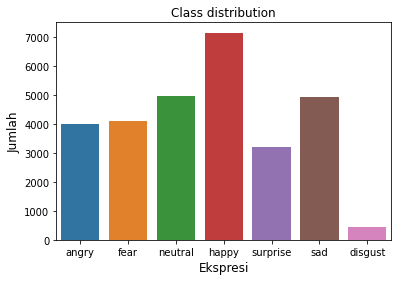

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(df_label.Ekspresi, df_label.Jumlah)
plt.title('Class distribution')
plt.ylabel('Jumlah', fontsize=12)
plt.xlabel('Ekspresi', fontsize=12)
plt.show()

In [ ]:
# Jumlah data training

jumlah_training = 0
jumlah_validation = 0 
jumlah_testing = 0
for nama_label in label:
    jumlah_train = len(os.listdir(os.path.join('train', nama_label)))
    jumlah_val = len(os.listdir(os.path.join('split-folders/validation', nama_label)))
    jumlah_test = len(os.listdir(os.path.join('split-folders/test', nama_label)))
    jumlah_training += jumlah_train
    jumlah_validation += jumlah_val
    jumlah_testing += jumlah_test

print('jumlah data training sebanyak', jumlah_training)
print('jumlah data validaiton sebanyak', jumlah_validation)
print('jumlah data test sebanyak', jumlah_testing)

jumlah data training sebanyak 28821
jumlah data validaiton sebanyak 4237
jumlah data test sebanyak 2829


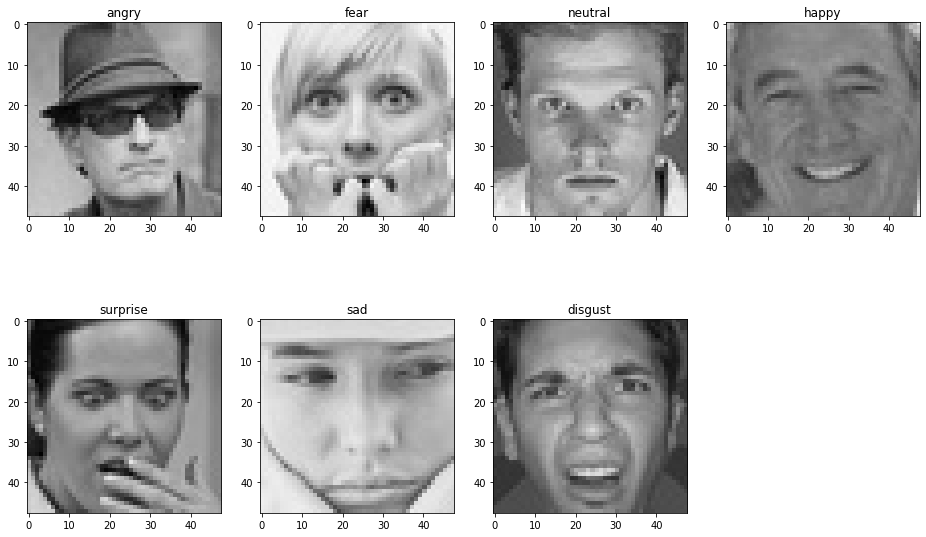

In [ ]:
def gambarWajah(gambar, jenis_ekpresi, path):
    #pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    #img = np.array(pixels.split())
    gambar_dir = os.path.join(path, jenis_ekpresi)
    gambar_path = os.path.join(gambar_dir, gambar)
    img = mpimg.imread(gambar_path)
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), jenis_ekpresi], dtype=object)

plt.figure(0, figsize=(16,10))
i = 1;
for nama_ekspresi in label:
    #print(nama_ekspresi)
    gambar_dir = os.path.join('train', nama_ekspresi)
    list_gambar_ekspresi = os.listdir(gambar_dir)
    nama_gambar = list_gambar_ekspresi[0]
    img = gambarWajah(nama_gambar, nama_ekspresi, 'train')
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])
    i+=1

plt.show()  

In [ ]:
#initilize parameters
jumlah_epochs = 200
ukuran_batch = 64

In [ ]:
# Image Data Generator
train_datagen = ImageDataGenerator(
      rotation_range = 10,
      width_shift_range = 0.1,
      height_shift_range = 0.1,
      zoom_range = 0.1,
      horizontal_flip = True,
      fill_mode = 'nearest'
)
validation_datagen = ImageDataGenerator()

In [ ]:
# Preprocess Data Biasa

train_generator = train_datagen.flow_from_directory(
    "train/",
    target_size=(48,48),
    batch_size = ukuran_batch,
    color_mode = 'grayscale',
    class_mode = "categorical"
)

validation_generator = validation_datagen.flow_from_directory(
    "split-folders/validation/",
    target_size=(48,48),
    batch_size = ukuran_batch,
    color_mode = 'grayscale',
    class_mode = "categorical"
)

Found 28821 images belonging to 7 classes.
Found 4237 images belonging to 7 classes.


In [ ]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.ZeroPadding2D((1,1), input_shape=(48,48,1)),
                                    tf.keras.layers.Conv2D(64, (3,3), padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.ZeroPadding2D((1,1)),
                                    tf.keras.layers.Conv2D(64, (3,3), padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                                    tf.keras.layers.Dropout(0.2),

                                    tf.keras.layers.ZeroPadding2D((1,1)),
                                    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.ZeroPadding2D((1,1)),
                                    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                                    tf.keras.layers.Dropout(0.2),

                                    tf.keras.layers.ZeroPadding2D((1,1)),
                                    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.ZeroPadding2D((1,1)),
                                    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                                    tf.keras.layers.Dropout(0.2),
                                    
                                    tf.keras.layers.ZeroPadding2D((1,1)),
                                    tf.keras.layers.Conv2D(512, (3,3), padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.ZeroPadding2D((1,1)),
                                    tf.keras.layers.Conv2D(512, (3,3), padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.ZeroPadding2D((1,1)),
                                    tf.keras.layers.Conv2D(512, (3,3), padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                                    tf.keras.layers.Dropout(0.2),

                                    tf.keras.layers.ZeroPadding2D((1,1)),
                                    tf.keras.layers.Conv2D(512, (3,3), padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.ZeroPadding2D((1,1)),
                                    tf.keras.layers.Conv2D(512, (3,3), padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.ZeroPadding2D((1,1)),
                                    tf.keras.layers.Conv2D(512, (3,3), padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                                    tf.keras.layers.Dropout(0.2),

                                    tf.keras.layers.ZeroPadding2D((1,1)),
                                    tf.keras.layers.Conv2D(512, (3,3), padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.ZeroPadding2D((1,1)),
                                    tf.keras.layers.Conv2D(512, (3,3), padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.ZeroPadding2D((1,1)),
                                    tf.keras.layers.Conv2D(512, (3,3), padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                                    tf.keras.layers.Dropout(0.2),

                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(4096),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(4096),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(2048),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(7, activation="softmax")
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_42 (ZeroPadd  (None, 50, 50, 1)        0         
 ing2D)                                                          
                                                                 
 conv2d_42 (Conv2D)          (None, 50, 50, 64)        640       
                                                                 
 batch_normalization_51 (Bat  (None, 50, 50, 64)       256       
 chNormalization)                                                
                                                                 
 activation_51 (Activation)  (None, 50, 50, 64)        0         
                                                                 
 zero_padding2d_43 (ZeroPadd  (None, 52, 52, 64)       0         
 ing2D)                                                          
                                                      

In [ ]:
# Compile model

model.compile(optimizer=Adam(lr=0.0001), loss="categorical_crossentropy", metrics = ["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Fit model

history = model.fit(
    train_generator, 
    validation_data = validation_generator,
    epochs=jumlah_epochs, 
    steps_per_epoch = jumlah_training/ukuran_batch,
    validation_steps = jumlah_validation/ukuran_batch,
    verbose = 1,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
)

Epoch 1/200
450/450 [==============================] - 107s 227ms/step - loss: 2.0009 - accuracy: 0.2089 - val_loss: 1.8755 - val_accuracy: 0.2587
Epoch 2/200
450/450 [==============================] - 103s 228ms/step - loss: 1.8862 - accuracy: 0.2299 - val_loss: 1.8863 - val_accuracy: 0.2617
Epoch 3/200
450/450 [==============================] - 104s 232ms/step - loss: 1.8488 - accuracy: 0.2506 - val_loss: 1.8583 - val_accuracy: 0.2662
Epoch 4/200
450/450 [==============================] - 105s 233ms/step - loss: 1.8300 - accuracy: 0.2611 - val_loss: 1.8389 - val_accuracy: 0.2712
Epoch 5/200
450/450 [==============================] - 105s 233ms/step - loss: 1.7725 - accuracy: 0.3010 - val_loss: 2.8536 - val_accuracy: 0.2318
Epoch 6/200
450/450 [==============================] - 105s 234ms/step - loss: 1.6404 - accuracy: 0.3744 - val_loss: 1.6942 - val_accuracy: 0.4017
Epoch 7/200
450/450 [==============================] - 105s 233ms/step - loss: 1.5373 - accuracy: 0.4127 - val_loss: 2

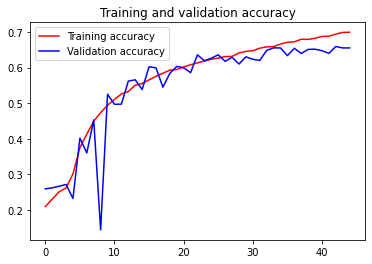

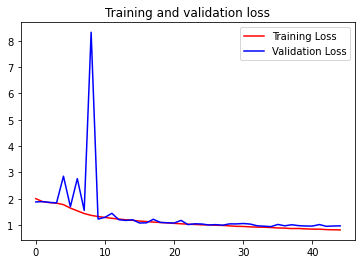

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    "split-folders/test/",
    target_size=(48,48),
    batch_size = ukuran_batch,
    color_mode = 'grayscale',
    class_mode = "categorical"
)

accuracy_score = model.evaluate(test_generator)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
print("Loss: ",accuracy_score[0])

Found 2829 images belonging to 7 classes.
45/45 [==============================] - 3s 68ms/step - loss: 0.9749 - accuracy: 0.6412
Accuracy: 64.1216%
Loss:  0.9749478697776794
